<a href="https://colab.research.google.com/github/SKaviani260/Ionic-Liquid-PVDF-Complexes/blob/main/DFT_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1351811246.py:128: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(errors.values(), labels=errors.keys())
/tmp/ipython-input-1351811246.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(cv_scores.values(), labels=cv_scores.keys(), positions=positions)
/tmp/ipython-input-1351811246.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


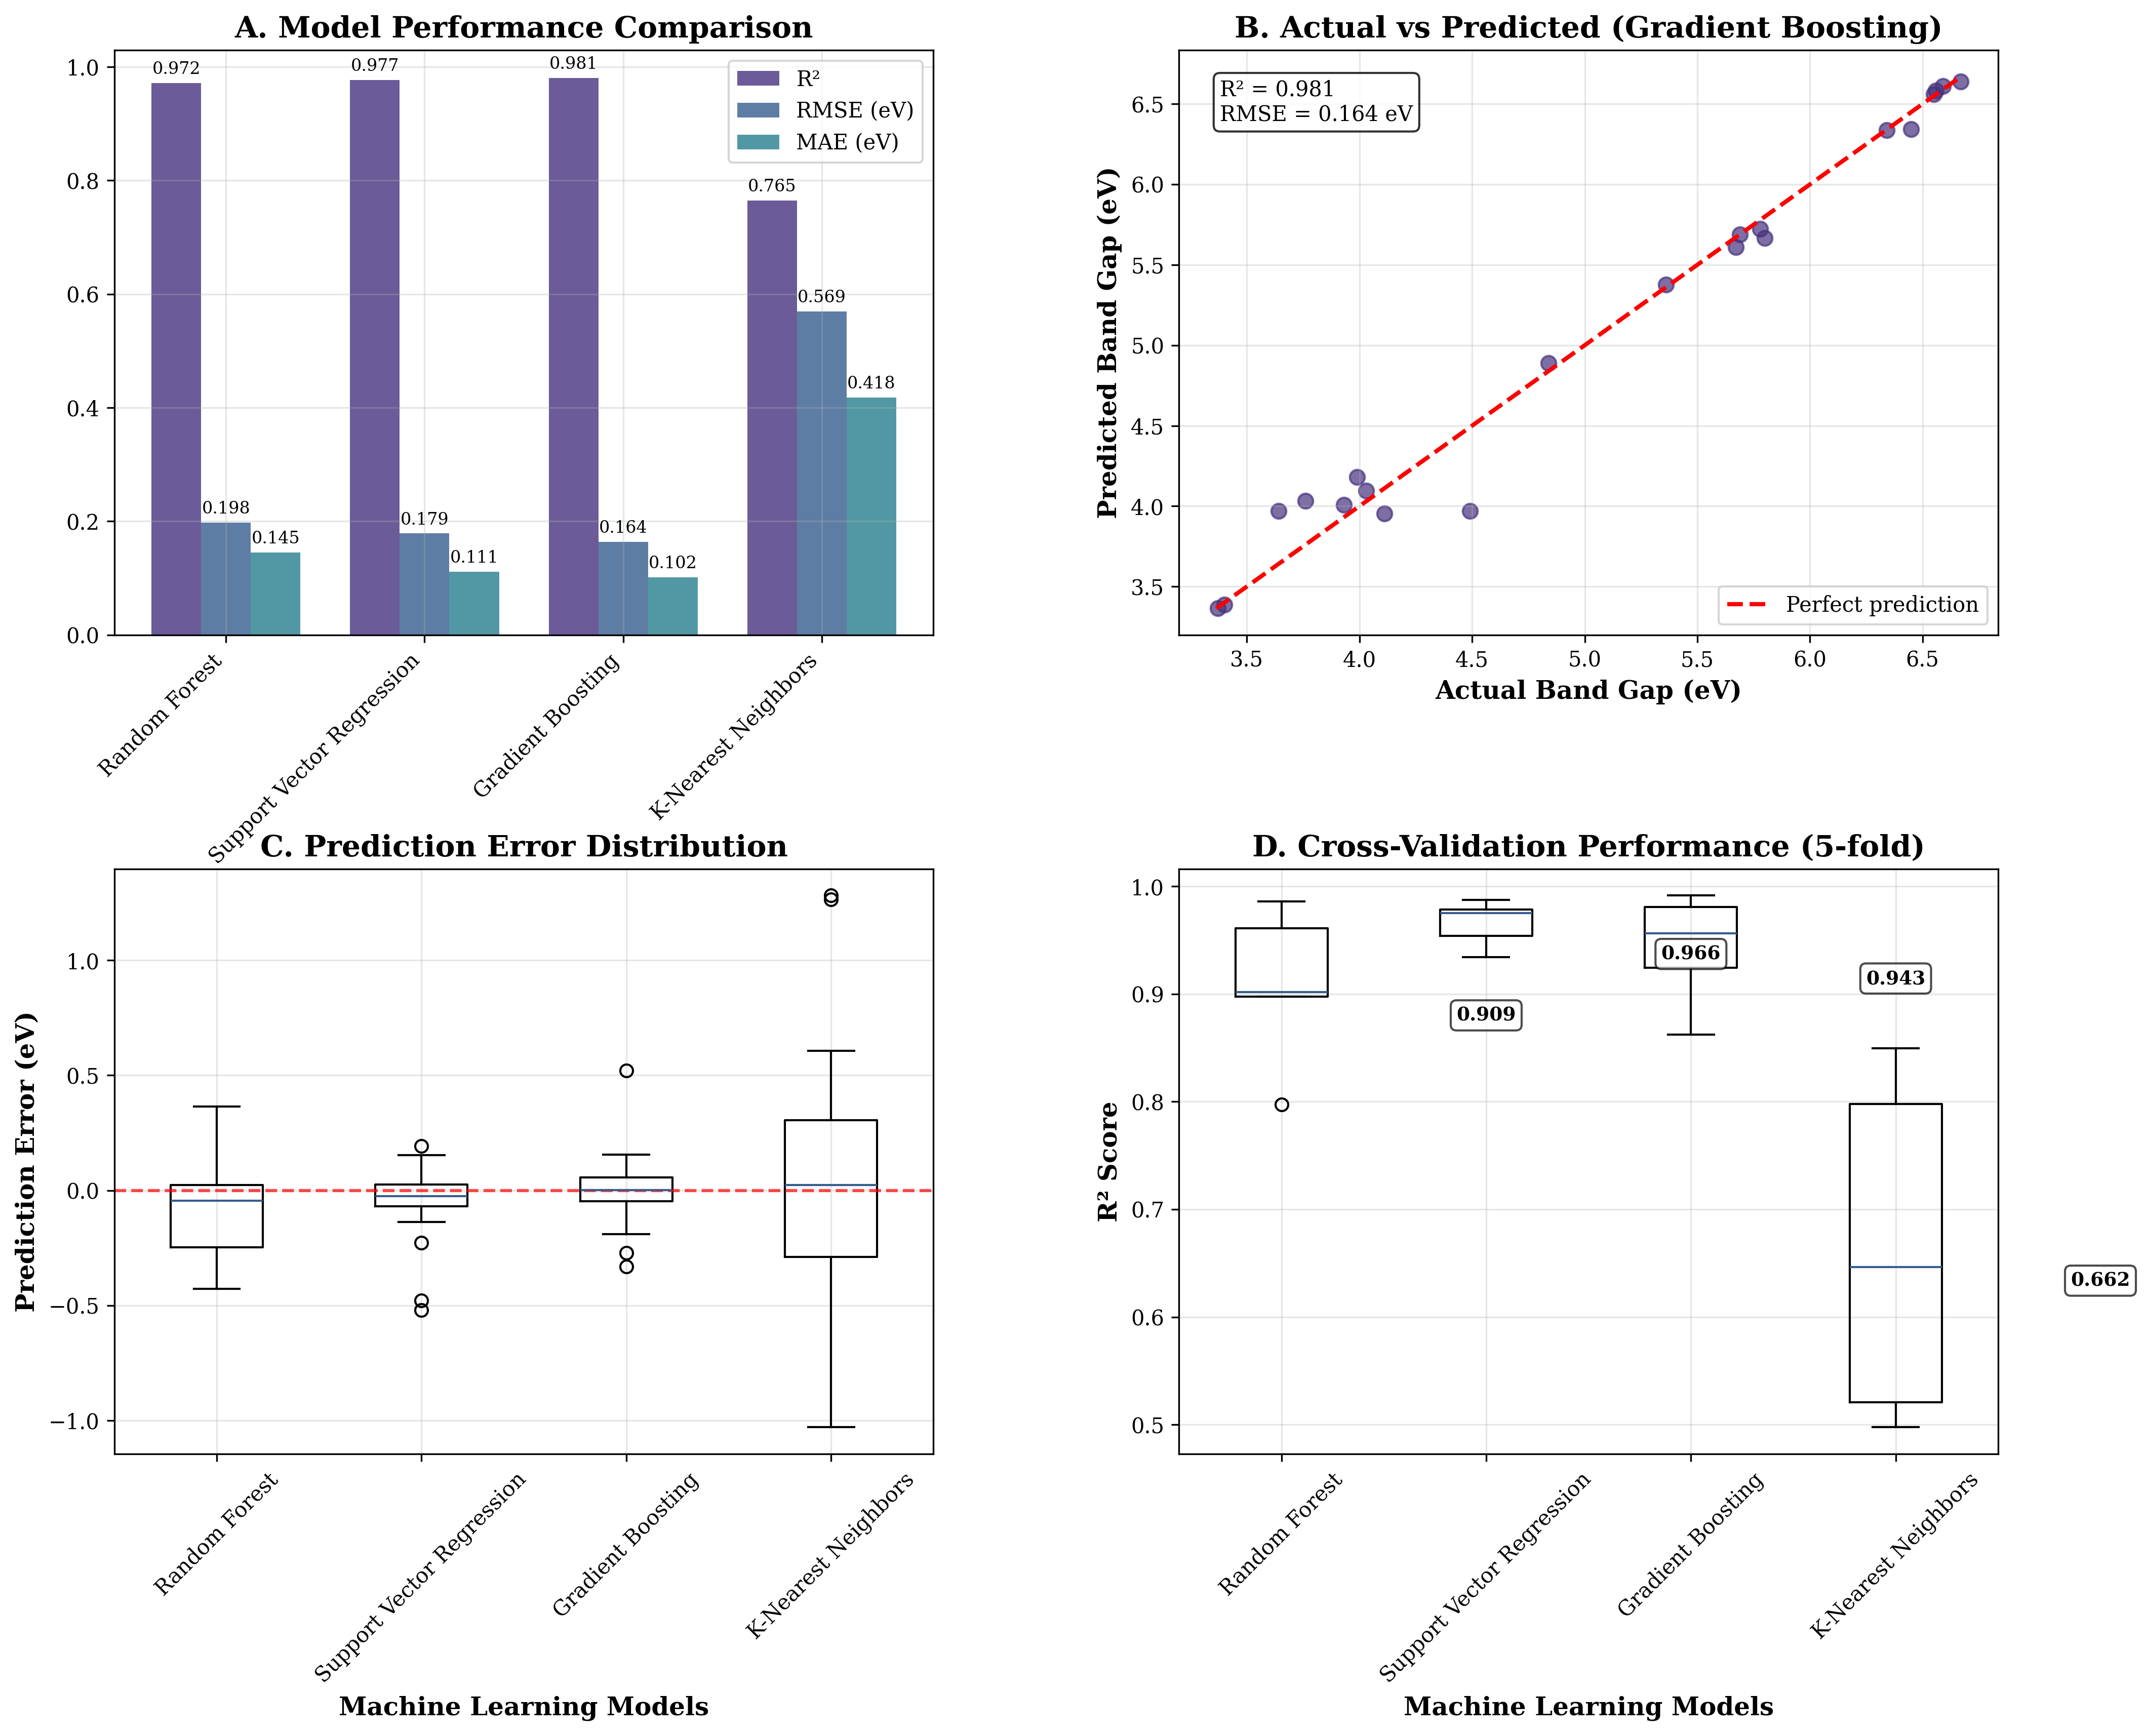

MODEL PERFORMANCE SUMMARY
                              R²   RMSE    MAE
Random Forest              0.972  0.198  0.145
Support Vector Regression  0.977  0.179  0.111
Gradient Boosting          0.981  0.164  0.102
K-Nearest Neighbors        0.765  0.569  0.418

Best performing model: Gradient Boosting
Best R²: 0.981
Best RMSE: 0.164 eV


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# Install required packages
!pip install scikit-learn xgboost matplotlib seaborn numpy

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec

# Set style for publication-quality figures
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# Load and prepare data
df = pd.read_excel('Dataset.xlsx', sheet_name='Sheet1')
features = ['EH(eV)', 'EL(eV)', 'IP (eV)', 'EA (eV)', 'Cation_group']
target = 'Eg (eV)'

# Convert categorical variables
df_encoded = pd.get_dummies(df[features + [target]], columns=['Cation_group'])
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=10, gamma='scale'),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Train models and collect results
results = {}
predictions = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    results[name] = {
        'R²': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

# Create 4-panel figure
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.4)

# Panel A: Model Performance Comparison (Bar chart)
ax1 = fig.add_subplot(gs[0, 0])
metrics_df = pd.DataFrame(results).T
x = np.arange(len(metrics_df))
width = 0.25

bars1 = ax1.bar(x - width, metrics_df['R²'], width, label='R²', alpha=0.8)
bars2 = ax1.bar(x, metrics_df['RMSE'], width, label='RMSE (eV)', alpha=0.8)
bars3 = ax1.bar(x + width, metrics_df['MAE'], width, label='MAE (eV)', alpha=0.8)

ax1.set_xlabel('Machine Learning Models', fontweight='bold')
ax1.set_title('A. Model Performance Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_df.index, rotation=45, ha='right')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Panel B: Actual vs Predicted Values
ax2 = fig.add_subplot(gs[0, 1])
best_model = min(results, key=lambda x: results[x]['RMSE'])
y_pred_best = predictions[best_model]

ax2.scatter(y_test, y_pred_best, alpha=0.7, s=50)
max_val = max(y_test.max(), y_pred_best.max())
min_val = min(y_test.min(), y_pred_best.min())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')

ax2.set_xlabel('Actual Band Gap (eV)', fontweight='bold')
ax2.set_ylabel('Predicted Band Gap (eV)', fontweight='bold')
ax2.set_title(f'B. Actual vs Predicted ({best_model})', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add performance metrics to plot
r2 = results[best_model]['R²']
rmse = results[best_model]['RMSE']
ax2.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.3f} eV',
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel C: Error Distribution
ax3 = fig.add_subplot(gs[1, 0])
errors = {}
for name, y_pred in predictions.items():
    errors[name] = y_test - y_pred

ax3.boxplot(errors.values(), labels=errors.keys())
ax3.axhline(y=0, color='r', linestyle='--', alpha=0.7)
ax3.set_xlabel('Machine Learning Models', fontweight='bold')
ax3.set_ylabel('Prediction Error (eV)', fontweight='bold')
ax3.set_title('C. Prediction Error Distribution', fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Panel D: Cross-Validation Performance
ax4 = fig.add_subplot(gs[1, 1])
cv_scores = {}
for name, model in models.items():
    cv_scores[name] = cross_val_score(model, X_train_scaled, y_train,
                                     cv=5, scoring='r2')

positions = np.arange(len(cv_scores))
bp = ax4.boxplot(cv_scores.values(), labels=cv_scores.keys(), positions=positions)
ax4.set_xlabel('Machine Learning Models', fontweight='bold')
ax4.set_ylabel('R² Score', fontweight='bold')
ax4.set_title('D. Cross-Validation Performance (5-fold)', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# Add mean values to boxplot
for i, (name, scores) in enumerate(cv_scores.items()):
    ax4.text(i + 1, np.mean(scores) - 0.02, f'{np.mean(scores):.3f}',
            ha='center', va='top', fontweight='bold', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('Figure_3_1_Model_Benchmarking.png', dpi=300, bbox_inches='tight')
plt.show()

# Print performance summary
print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
performance_df = pd.DataFrame(results).T
print(performance_df.round(3))

print(f"\nBest performing model: {best_model}")
print(f"Best R²: {performance_df.loc[best_model, 'R²']:.3f}")
print(f"Best RMSE: {performance_df.loc[best_model, 'RMSE']:.3f} eV")

# Download the figure
from google.colab import files
files.download('Figure_3_1_Model_Benchmarking.png')

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Dataset.xlsx to Dataset.xlsx


/tmp/ipython-input-3014301194.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


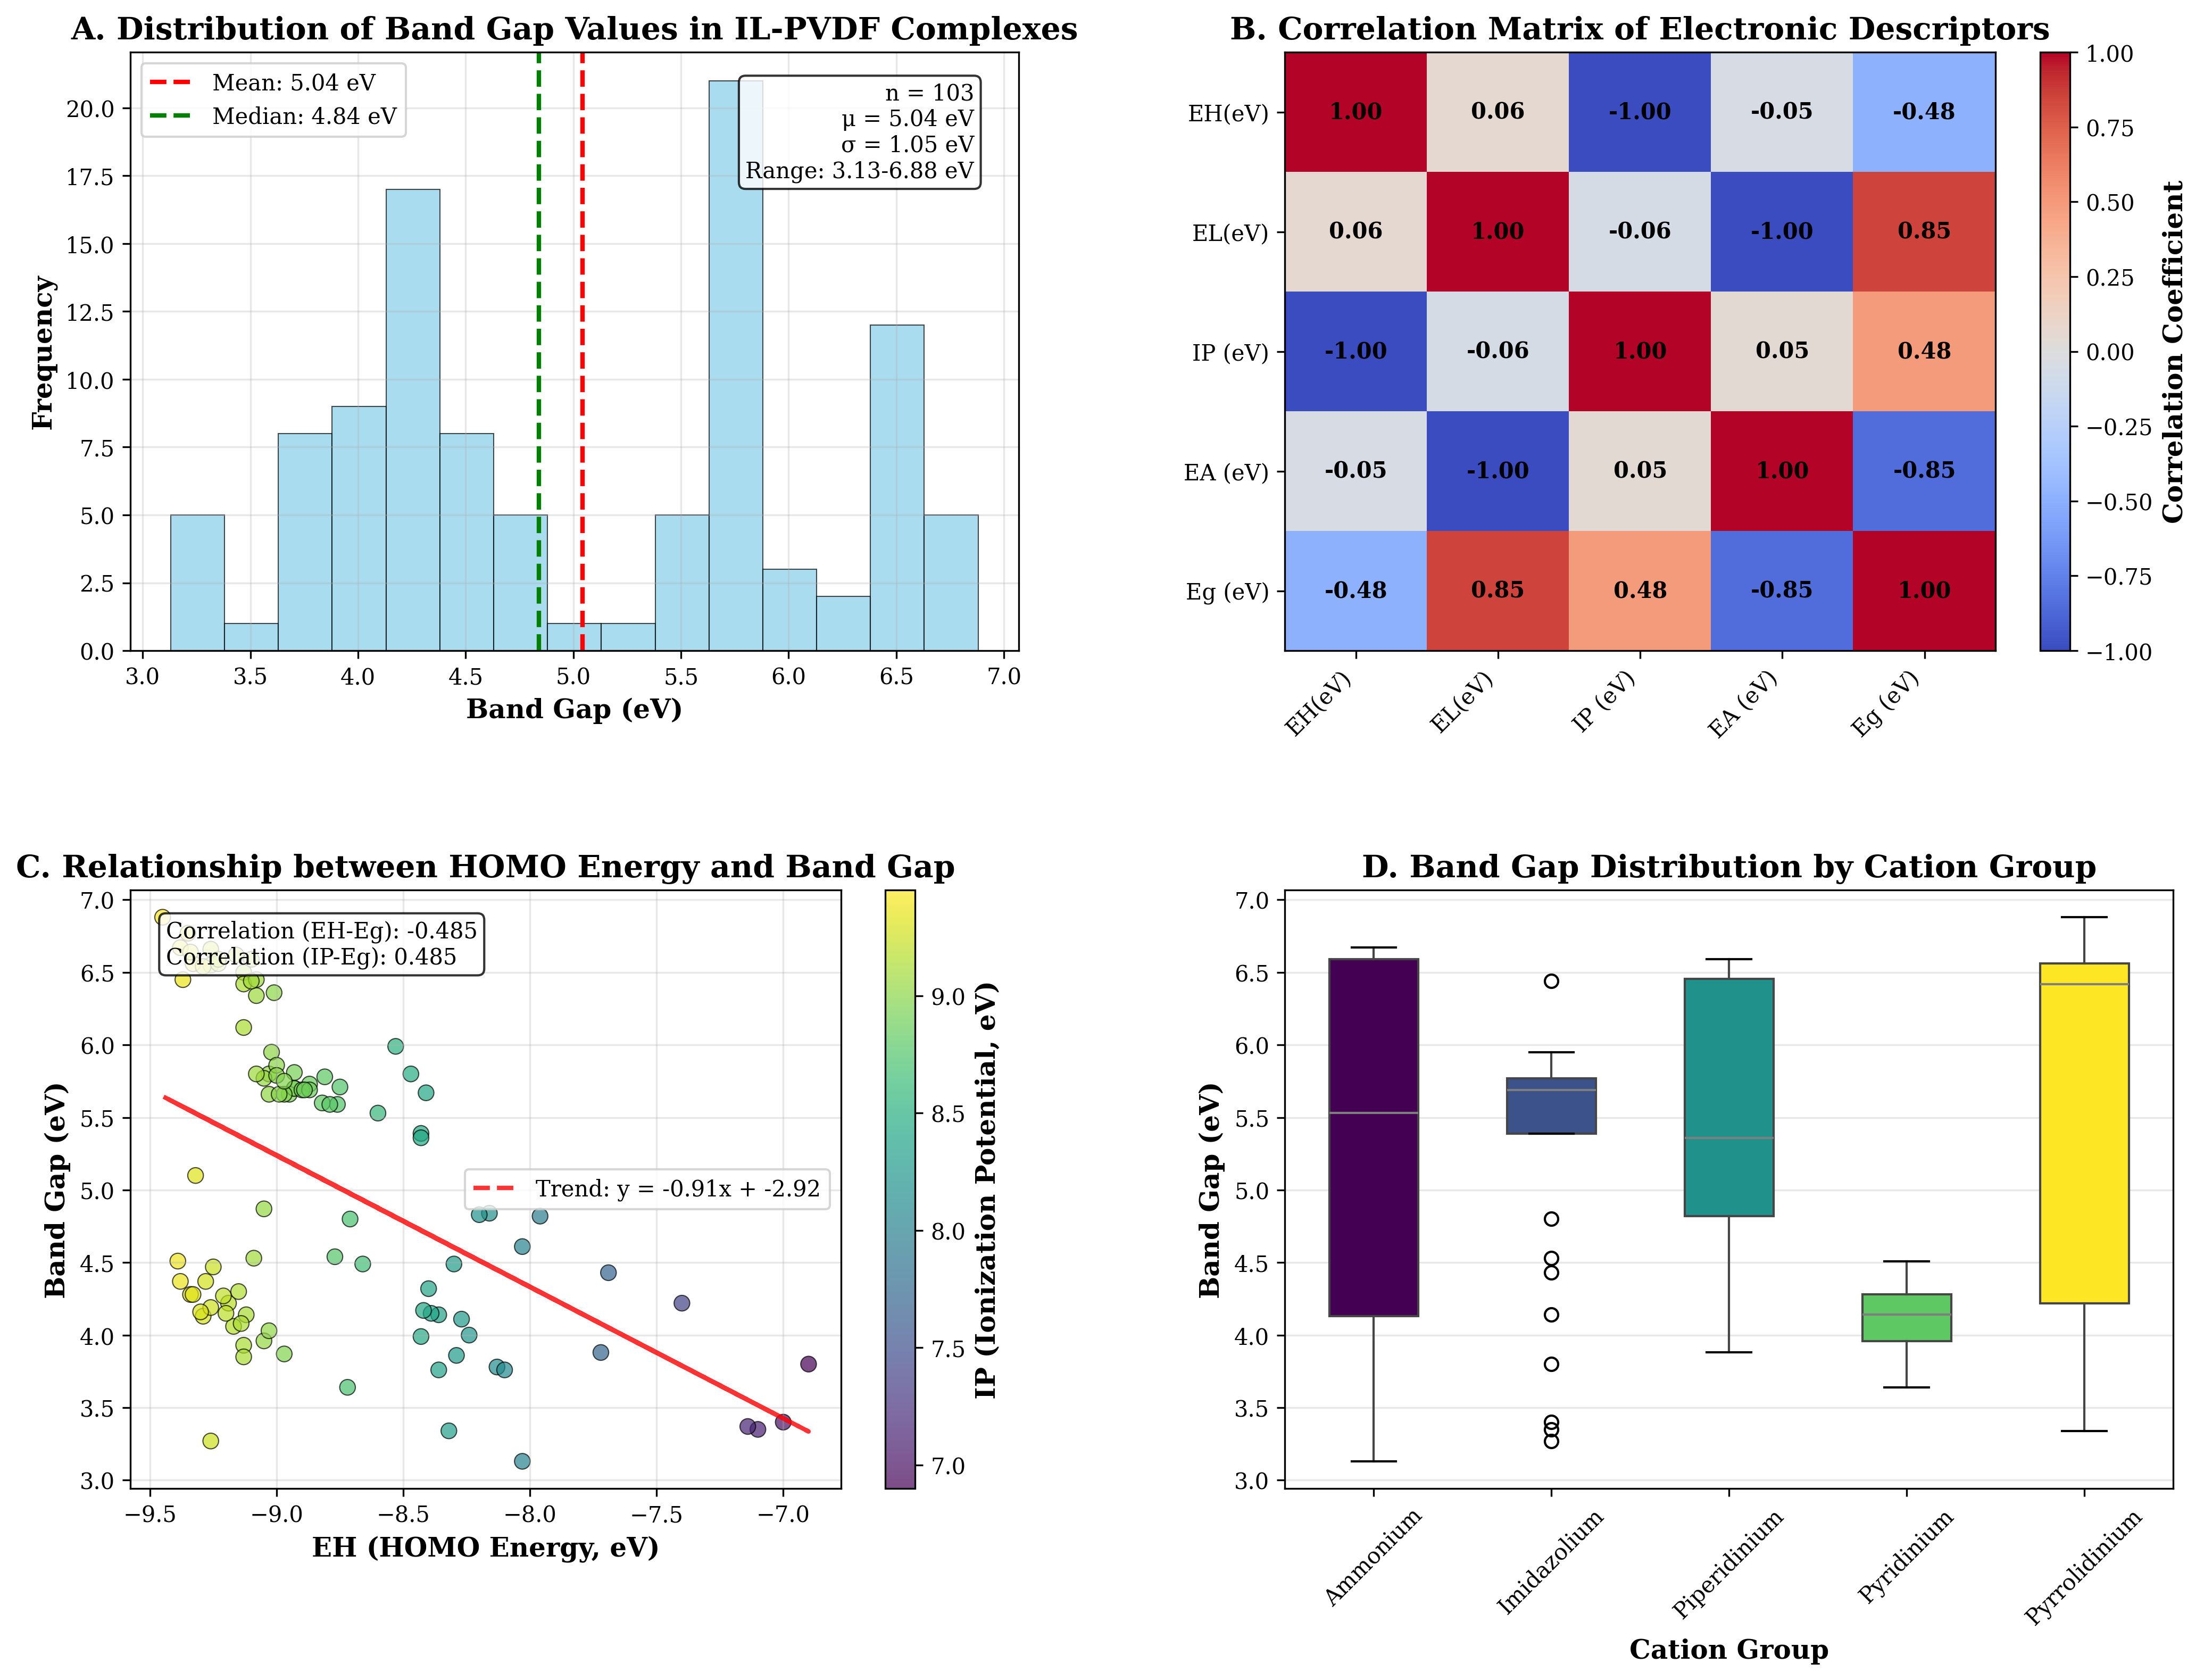

DESCRIPTOR ANALYSIS SUMMARY
Band Gap Statistics:
  Mean: 5.044 eV
  Std: 1.051 eV
  Min: 3.130 eV
  Max: 6.880 eV
  Range: 3.750 eV

Correlation with Band Gap:
  EH(eV): -0.485
  EL(eV): 0.846
  IP (eV): 0.485
  EA (eV): -0.847

Cation Groups with sufficient data:
  Imidazolium: n=33, mean Eg=5.309 eV
  Pyridinium: n=25, mean Eg=4.112 eV
  Ammonium: n=15, mean Eg=5.279 eV
  Pyrrolidinium: n=13, mean Eg=5.474 eV
  Piperidinium: n=7, mean Eg=5.483 eV


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
!pip install scikit-learn matplotlib seaborn numpy

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec
from scipy import stats

# Set style for publication-quality figures
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# Load and prepare data
df = pd.read_excel('Dataset.xlsx', sheet_name='Sheet1')
features = ['EH(eV)', 'EL(eV)', 'IP (eV)', 'EA (eV)', 'Cation_group']
target = 'Eg (eV)'

# Convert categorical variables
df_encoded = pd.get_dummies(df[features + [target]], columns=['Cation_group'])
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

# Create 4-panel figure
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.4)

# Panel A: Distribution of Band Gap Values
ax1 = fig.add_subplot(gs[0, 0])
n, bins, patches = ax1.hist(y, bins=15, alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
ax1.axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y.mean():.2f} eV')
ax1.axvline(y.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {y.median():.2f} eV')

ax1.set_xlabel('Band Gap (eV)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('A. Distribution of Band Gap Values in IL-PVDF Complexes', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add statistical annotations
stats_text = f'n = {len(y)}\nμ = {y.mean():.2f} eV\nσ = {y.std():.2f} eV\nRange: {y.min():.2f}-{y.max():.2f} eV'
ax1.text(0.95, 0.95, stats_text, transform=ax1.transAxes, verticalalignment='top',
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel B: Correlation Matrix of Electronic Descriptors
ax2 = fig.add_subplot(gs[0, 1])
# Select only electronic descriptors
electronic_features = ['EH(eV)', 'EL(eV)', 'IP (eV)', 'EA (eV)', 'Eg (eV)']
corr_matrix = df[electronic_features].corr()

# Create heatmap
im = ax2.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax2.set_xticks(np.arange(len(corr_matrix.columns)))
ax2.set_yticks(np.arange(len(corr_matrix.columns)))
ax2.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax2.set_yticklabels(corr_matrix.columns)

# Add correlation values to heatmap
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax2.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold')

ax2.set_title('B. Correlation Matrix of Electronic Descriptors', fontweight='bold')
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Correlation Coefficient', fontweight='bold')

# Panel C: Relationship between EH/IP and Band Gap
ax3 = fig.add_subplot(gs[1, 0])
scatter = ax3.scatter(df['EH(eV)'], y, c=df['IP (eV)'], cmap='viridis',
                     alpha=0.7, s=50, edgecolors='black', linewidth=0.5)

# Add trendline
z = np.polyfit(df['EH(eV)'], y, 1)
p = np.poly1d(z)
ax3.plot(df['EH(eV)'], p(df['EH(eV)']), "r--", alpha=0.8, linewidth=2,
         label=f'Trend: y = {z[0]:.2f}x + {z[1]:.2f}')

ax3.set_xlabel('EH (HOMO Energy, eV)', fontweight='bold')
ax3.set_ylabel('Band Gap (eV)', fontweight='bold')
ax3.set_title('C. Relationship between HOMO Energy and Band Gap', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add colorbar for IP
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('IP (Ionization Potential, eV)', fontweight='bold')

# Calculate and display correlation
eh_corr = df['EH(eV)'].corr(y)
ip_corr = df['IP (eV)'].corr(y)
ax3.text(0.05, 0.95, f'Correlation (EH-Eg): {eh_corr:.3f}\nCorrelation (IP-Eg): {ip_corr:.3f}',
         transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel D: Band Gap Distribution by Cation Group
ax4 = fig.add_subplot(gs[1, 1])
# Get cation groups with sufficient data
cation_counts = df['Cation_group'].value_counts()
significant_cations = cation_counts[cation_counts >= 5].index.tolist()
filtered_df = df[df['Cation_group'].isin(significant_cations)]

# Create boxplot
boxplot = filtered_df.boxplot(column='Eg (eV)', by='Cation_group', ax=ax4,
                             patch_artist=True, grid=False)
ax4.set_title('D. Band Gap Distribution by Cation Group', fontweight='bold')
ax4.set_xlabel('Cation Group', fontweight='bold')
ax4.set_ylabel('Band Gap (eV)', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)

# Color the boxes
colors = plt.cm.viridis(np.linspace(0, 1, len(significant_cations)))
for patch, color in zip(boxplot.findobj(plt.matplotlib.patches.PathPatch), colors):
    patch.set_facecolor(color)

ax4.grid(True, alpha=0.3, axis='y')

# Remove the automatic "Boxplot grouped by" title
plt.suptitle('')  # Clear the overall title that pandas boxplot adds

plt.tight_layout()
plt.savefig('Figure_3_2_Descriptor_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistical summary
print("="*60)
print("DESCRIPTOR ANALYSIS SUMMARY")
print("="*60)
print(f"Band Gap Statistics:")
print(f"  Mean: {y.mean():.3f} eV")
print(f"  Std: {y.std():.3f} eV")
print(f"  Min: {y.min():.3f} eV")
print(f"  Max: {y.max():.3f} eV")
print(f"  Range: {y.max() - y.min():.3f} eV")

print(f"\nCorrelation with Band Gap:")
for feature in ['EH(eV)', 'EL(eV)', 'IP (eV)', 'EA (eV)']:
    corr = df[feature].corr(y)
    print(f"  {feature}: {corr:.3f}")

print(f"\nCation Groups with sufficient data:")
for cation in significant_cations:
    n = len(filtered_df[filtered_df['Cation_group'] == cation])
    mean_eg = filtered_df[filtered_df['Cation_group'] == cation]['Eg (eV)'].mean()
    print(f"  {cation}: n={n}, mean Eg={mean_eg:.3f} eV")

# Download the figure
from google.colab import files
files.download('Figure_3_2_Descriptor_Analysis.png')

/tmp/ipython-input-189814440.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax1.boxplot(boxplot_data, labels=major_cations, patch_artist=True)
/tmp/ipython-input-189814440.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


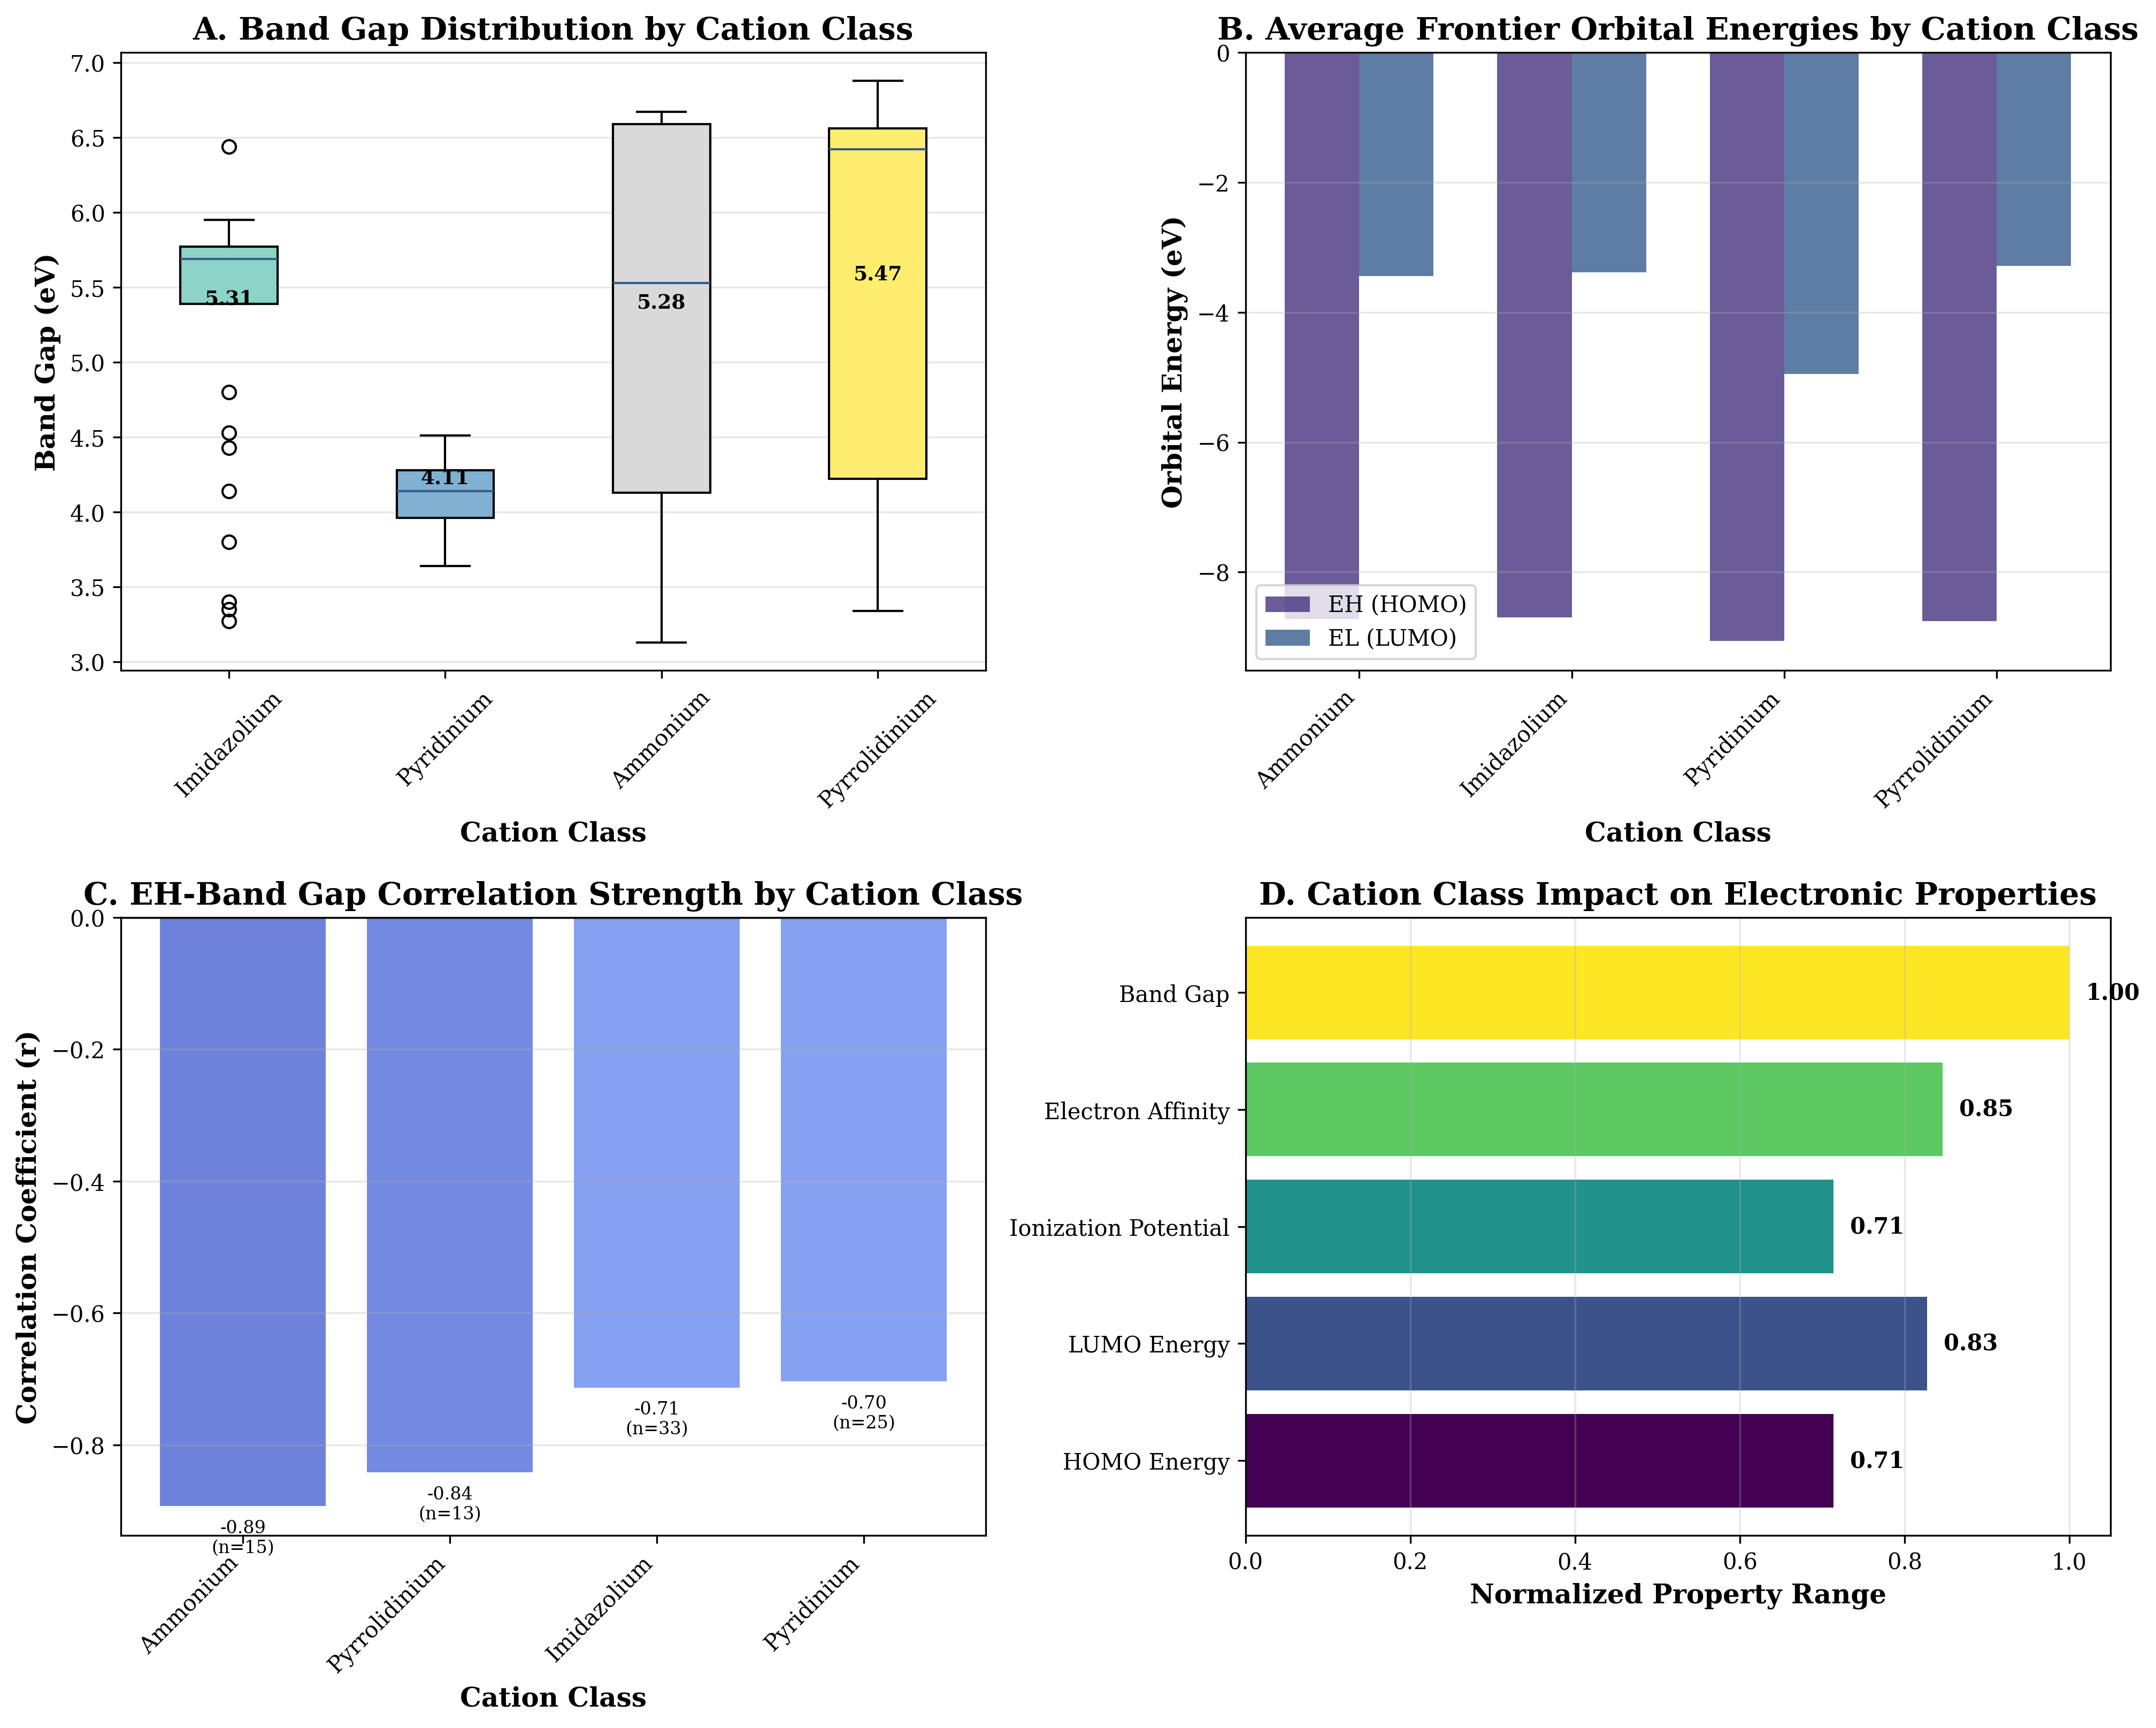

CATION CLASS INFLUENCE ANALYSIS

Band Gap Statistics by Cation Class:
  Imidazolium: 5.309 ± 0.835 eV (n=33)
  Pyridinium: 4.112 ± 0.226 eV (n=25)
  Ammonium: 5.279 ± 1.363 eV (n=15)
  Pyrrolidinium: 5.474 ± 1.323 eV (n=13)

ANOVA Results for Band Gap Across Cation Classes:
  F-statistic: 10.428, p-value: 6.945e-06

Correlation between EH and Band Gap by Cation Class:
  Ammonium: r = -0.893 (n=15)
  Pyrrolidinium: r = -0.842 (n=13)
  Imidazolium: r = -0.713 (n=33)
  Pyridinium: r = -0.704 (n=25)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# Install required packages
!pip install scikit-learn matplotlib seaborn numpy

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.gridspec as gridspec

# Set style for publication-quality figures
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# Load and prepare data
df = pd.read_excel('Dataset.xlsx', sheet_name='Sheet1')

# Filter for major cation groups with sufficient data
cation_counts = df['Cation_group'].value_counts()
major_cations = cation_counts[cation_counts >= 8].index.tolist()
filtered_df = df[df['Cation_group'].isin(major_cations)]

# Create 4-panel figure
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.4)

# Panel A: Band Gap Comparison Across Cation Classes
ax1 = fig.add_subplot(gs[0, 0])
boxplot_data = [filtered_df[filtered_df['Cation_group'] == cation]['Eg (eV)'].values
                for cation in major_cations]

box = ax1.boxplot(boxplot_data, labels=major_cations, patch_artist=True)
# Add colors to boxes
colors = plt.cm.Set3(np.linspace(0, 1, len(major_cations)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_xlabel('Cation Class', fontweight='bold')
ax1.set_ylabel('Band Gap (eV)', fontweight='bold')
ax1.set_title('A. Band Gap Distribution by Cation Class', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Add mean values
means = [np.mean(data) for data in boxplot_data]
for i, mean in enumerate(means):
    ax1.text(i+1, mean + 0.05, f'{mean:.2f}', ha='center', va='bottom',
             fontweight='bold', fontsize=9)

# Panel B: Frontier Orbital Energies by Cation Class
ax2 = fig.add_subplot(gs[0, 1])
cation_means = filtered_df.groupby('Cation_group')[['EH(eV)', 'EL(eV)']].mean()
x_pos = np.arange(len(cation_means))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, cation_means['EH(eV)'], width,
                label='EH (HOMO)', alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, cation_means['EL(eV)'], width,
                label='EL (LUMO)', alpha=0.8)

ax2.set_xlabel('Cation Class', fontweight='bold')
ax2.set_ylabel('Orbital Energy (eV)', fontweight='bold')
ax2.set_title('B. Average Frontier Orbital Energies by Cation Class', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(cation_means.index, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Panel C: Electronic Properties Correlation by Cation Class
ax3 = fig.add_subplot(gs[1, 0])
# Calculate correlation between EH and Eg for each cation group
correlations = []
for cation in major_cations:
    cation_data = filtered_df[filtered_df['Cation_group'] == cation]
    if len(cation_data) > 2:
        corr = cation_data['EH(eV)'].corr(cation_data['Eg (eV)'])
        correlations.append((cation, corr, len(cation_data)))

correlations.sort(key=lambda x: x[1])  # Sort by correlation strength
cations_sorted, corrs, counts = zip(*correlations)

colors = plt.cm.coolwarm((np.array(corrs) + 1) / 2)  # Color by correlation strength

bars = ax3.bar(range(len(corrs)), corrs, color=colors, alpha=0.8)
ax3.set_xlabel('Cation Class', fontweight='bold')
ax3.set_ylabel('Correlation Coefficient (r)', fontweight='bold')
ax3.set_title('C. EH-Band Gap Correlation Strength by Cation Class', fontweight='bold')
ax3.set_xticks(range(len(corrs)))
ax3.set_xticklabels(cations_sorted, rotation=45, ha='right')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3, axis='y')

# Add correlation values and sample sizes
for i, (corr, count) in enumerate(zip(corrs, counts)):
    ax3.text(i, corr + (0.02 if corr > 0 else -0.02), f'{corr:.2f}\n(n={count})',
             ha='center', va='bottom' if corr > 0 else 'top', fontsize=8)

# Panel D: Cation Class Impact on Electronic Properties
ax4 = fig.add_subplot(gs[1, 1])
properties = ['EH(eV)', 'EL(eV)', 'IP (eV)', 'EA (eV)', 'Eg (eV)']
property_names = ['HOMO Energy', 'LUMO Energy', 'Ionization Potential',
                  'Electron Affinity', 'Band Gap']

# Calculate normalized range for each property by cation group
normalized_ranges = []
for prop in properties:
    ranges = []
    for cation in major_cations:
        cation_data = filtered_df[filtered_df['Cation_group'] == cation][prop]
        if len(cation_data) > 1:
            prop_range = cation_data.max() - cation_data.min()
            ranges.append(prop_range)
    normalized_ranges.append(np.mean(ranges) if ranges else 0)

# Normalize by maximum range
max_range = max(normalized_ranges)
normalized_ranges = [r/max_range for r in normalized_ranges]

bars = ax4.barh(property_names, normalized_ranges, color=plt.cm.viridis(np.linspace(0, 1, len(properties))))
ax4.set_xlabel('Normalized Property Range', fontweight='bold')
ax4.set_title('D. Cation Class Impact on Electronic Properties', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Add actual range values
for i, (prop, range_val) in enumerate(zip(property_names, normalized_ranges)):
    ax4.text(range_val + 0.02, i, f'{range_val:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('Figure_3_3_Cation_Influence.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistical analysis
print("="*60)
print("CATION CLASS INFLUENCE ANALYSIS")
print("="*60)

print("\nBand Gap Statistics by Cation Class:")
for cation in major_cations:
    cation_data = filtered_df[filtered_df['Cation_group'] == cation]
    mean_eg = cation_data['Eg (eV)'].mean()
    std_eg = cation_data['Eg (eV)'].std()
    n = len(cation_data)
    print(f"  {cation}: {mean_eg:.3f} ± {std_eg:.3f} eV (n={n})")

print("\nANOVA Results for Band Gap Across Cation Classes:")
groups = [filtered_df[filtered_df['Cation_group'] == cation]['Eg (eV)'].values
          for cation in major_cations]
f_stat, p_value = stats.f_oneway(*groups)
print(f"  F-statistic: {f_stat:.3f}, p-value: {p_value:.3e}")

print("\nCorrelation between EH and Band Gap by Cation Class:")
for cation, corr, count in correlations:
    print(f"  {cation}: r = {corr:.3f} (n={count})")

# Download the figure
from google.colab import files
files.download('Figure_3_3_Cation_Influence.png')

/tmp/ipython-input-3505080478.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


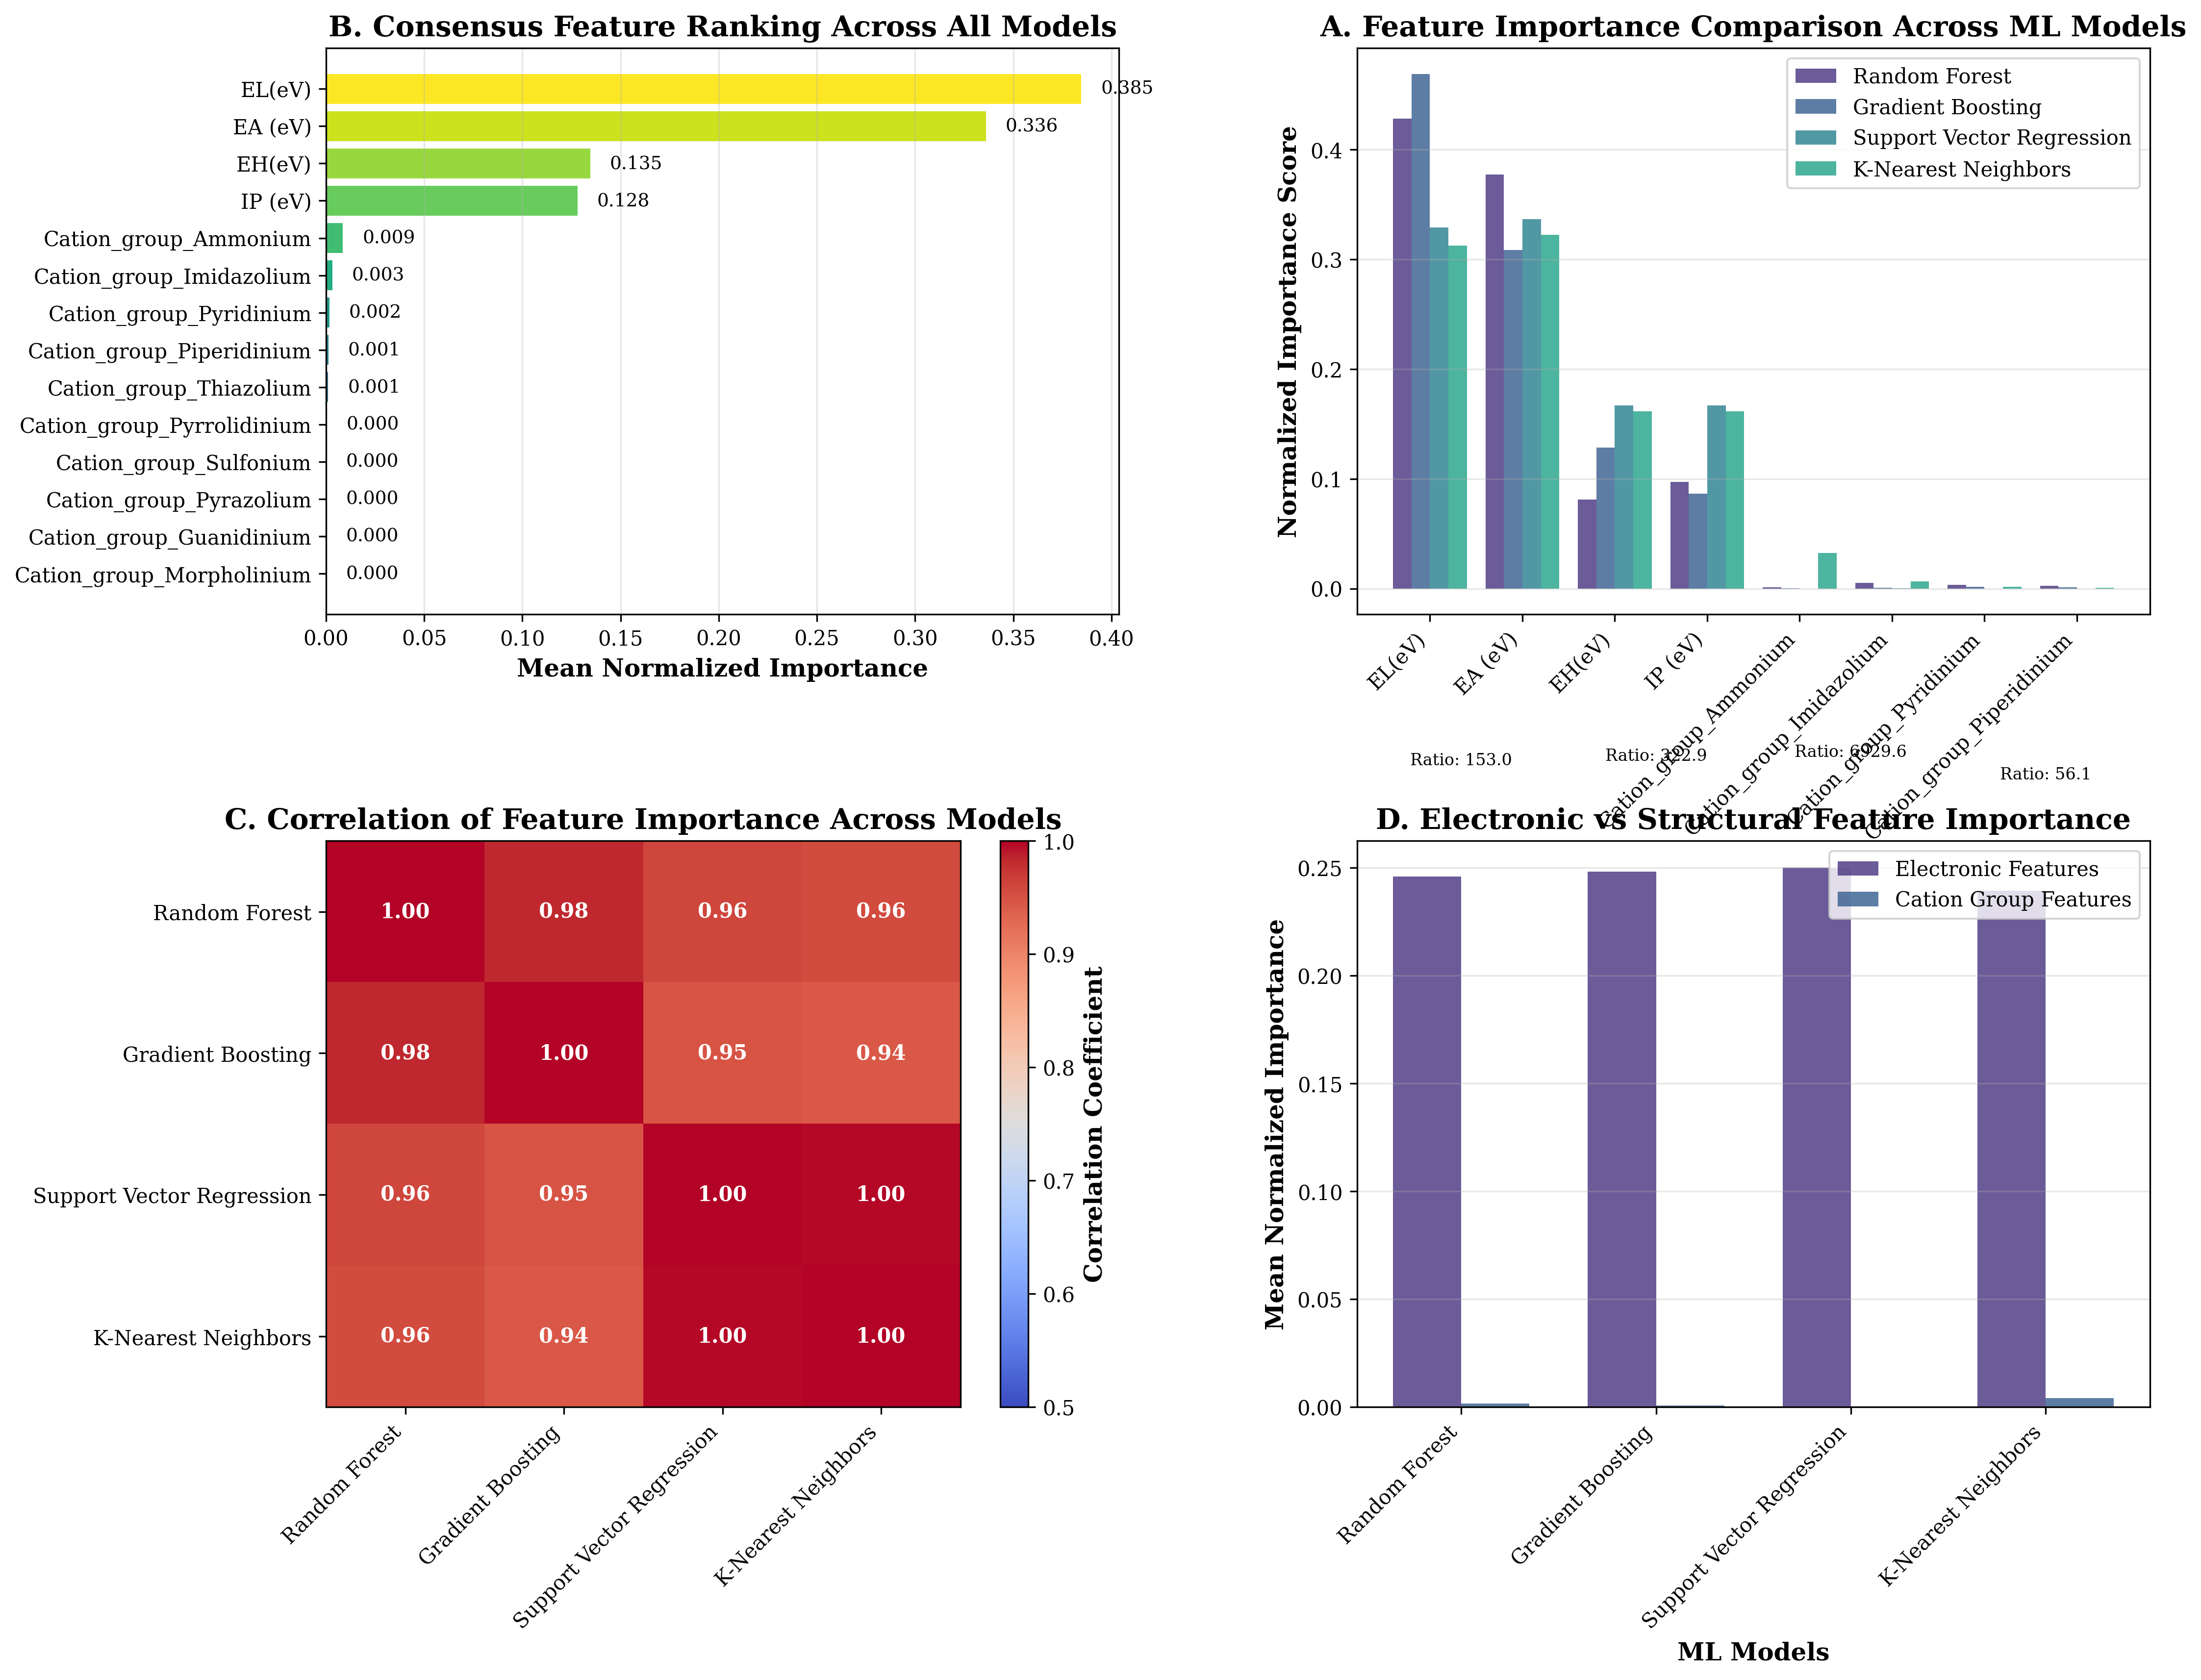

FEATURE IMPORTANCE ANALYSIS

Top 5 Most Important Features (Consensus):
  1. EL(eV): 0.385
  2. EA (eV): 0.336
  3. EH(eV): 0.135
  4. IP (eV): 0.128
  5. Cation_group_Ammonium: 0.009

Feature Importance Correlation Across Models:
                           Random Forest  Gradient Boosting  \
Random Forest                      1.000              0.984   
Gradient Boosting                  0.984              1.000   
Support Vector Regression          0.959              0.948   
K-Nearest Neighbors                0.956              0.945   

                           Support Vector Regression  K-Nearest Neighbors  
Random Forest                                  0.959                0.956  
Gradient Boosting                              0.948                0.945  
Support Vector Regression                      1.000                0.997  
K-Nearest Neighbors                            0.997                1.000  

Electronic vs Cation Feature Importance Ratio:
  Random Forest: 152.98 (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Install required packages
!pip install scikit-learn matplotlib seaborn numpy xgboost

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import matplotlib.gridspec as gridspec

# Set style for publication-quality figures
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# Load and prepare data
df = pd.read_excel('Dataset.xlsx', sheet_name='Sheet1')
features = ['EH(eV)', 'EL(eV)', 'IP (eV)', 'EA (eV)', 'Cation_group']
target = 'Eg (eV)'

# Convert categorical variables
df_encoded = pd.get_dummies(df[features + [target]], columns=['Cation_group'])
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=10, gamma='scale'),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Train models and compute feature importance
feature_importance_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    # Get model-specific feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
        # If coef_ is 1D but we have multiple features, handle appropriately
        if len(importance) != len(X.columns):
            importance = np.abs(model.coef_[0]) if hasattr(model.coef_, '__len__') and len(model.coef_) > 0 else np.zeros(len(X.columns))
    else:
        # For models without built-in importance, use permutation importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importance = perm_importance.importances_mean

    # Ensure importance array has correct length
    if len(importance) == len(X.columns):
        feature_importance_results[name] = pd.Series(importance, index=X.columns)
    else:
        # If importance array doesn't match, create a default one
        feature_importance_results[name] = pd.Series(np.ones(len(X.columns)) / len(X.columns), index=X.columns)

# Create normalized importance dataframe
importance_df = pd.DataFrame(feature_importance_results)
importance_df_normalized = importance_df.div(importance_df.sum(axis=0), axis=1)

# Create 4-panel figure with reordered layout: B, A, C, D
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.4)

# Panel B: Consensus Feature Ranking (FIRST POSITION - Top Left)
ax2 = fig.add_subplot(gs[0, 0])
mean_importance = importance_df_normalized.mean(axis=1).sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(mean_importance)))

bars = ax2.barh(range(len(mean_importance)), mean_importance.values, color=colors)
ax2.set_yticks(range(len(mean_importance)))
ax2.set_yticklabels(mean_importance.index)
ax2.set_xlabel('Mean Normalized Importance', fontweight='bold')
ax2.set_title('B. Consensus Feature Ranking Across All Models', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add values to bars
for i, (feature, importance) in enumerate(mean_importance.items()):
    ax2.text(importance + 0.01, i, f'{importance:.3f}', va='center', fontsize=9)

# Panel A: Feature Importance Comparison Across Models (SECOND POSITION - Top Right)
ax1 = fig.add_subplot(gs[0, 1])
# Select top 8 features across all models
top_features = importance_df_normalized.mean(axis=1).sort_values(ascending=False).head(8).index
importance_top = importance_df_normalized.loc[top_features]

# Create grouped bar chart
x = np.arange(len(top_features))
width = 0.2
for i, (model_name, importance_vals) in enumerate(importance_top.items()):
    ax1.bar(x + i*width, importance_vals.values, width, label=model_name, alpha=0.8)

ax1.set_xlabel('Features', fontweight='bold')
ax1.set_ylabel('Normalized Importance Score', fontweight='bold')
ax1.set_title('A. Feature Importance Comparison Across ML Models', fontweight='bold')
ax1.set_xticks(x + width*1.5)
ax1.set_xticklabels(top_features, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Panel C: Model-Specific Feature Importance Patterns (THIRD POSITION - Bottom Left)
ax3 = fig.add_subplot(gs[1, 0])
# Calculate correlation matrix of feature importance across models
importance_corr = importance_df_normalized.corr()

# Create heatmap
im = ax3.imshow(importance_corr, cmap='coolwarm', vmin=0.5, vmax=1.0, aspect='auto')
ax3.set_xticks(np.arange(len(importance_corr.columns)))
ax3.set_yticks(np.arange(len(importance_corr.columns)))
ax3.set_xticklabels(importance_corr.columns, rotation=45, ha='right')
ax3.set_yticklabels(importance_corr.columns)

# Add correlation values
for i in range(len(importance_corr.columns)):
    for j in range(len(importance_corr.columns)):
        text = ax3.text(j, i, f'{importance_corr.iloc[i, j]:.2f}',
                       ha="center", va="center", color="white" if abs(importance_corr.iloc[i, j]) > 0.7 else "black",
                       fontweight='bold')

ax3.set_title('C. Correlation of Feature Importance Across Models', fontweight='bold')
cbar = plt.colorbar(im, ax=ax3)
cbar.set_label('Correlation Coefficient', fontweight='bold')

# Panel D: Electronic vs Structural Feature Importance (FOURTH POSITION - Bottom Right)
ax4 = fig.add_subplot(gs[1, 1])
# Classify features
electronic_features = ['EH(eV)', 'EL(eV)', 'IP (eV)', 'EA (eV)']
cation_features = [col for col in X.columns if 'Cation_group' in col]

electronic_importance = importance_df_normalized.loc[electronic_features].mean(axis=0)
cation_importance = importance_df_normalized.loc[cation_features].mean(axis=0)

x = np.arange(len(models))
width = 0.35

bars1 = ax4.bar(x - width/2, electronic_importance, width, label='Electronic Features', alpha=0.8)
bars2 = ax4.bar(x + width/2, cation_importance, width, label='Cation Group Features', alpha=0.8)

ax4.set_xlabel('ML Models', fontweight='bold')
ax4.set_ylabel('Mean Normalized Importance', fontweight='bold')
ax4.set_title('D. Electronic vs Structural Feature Importance', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(models.keys(), rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add ratio values
for i, (model_name, e_imp, c_imp) in enumerate(zip(models.keys(), electronic_importance, cation_importance)):
    ratio = e_imp / c_imp if c_imp > 0 else float('inf')
    ax4.text(i, max(e_imp, c_imp) + 0.05, f'Ratio: {ratio:.1f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('Figure_3_4_Feature_Importance_Analysis_Reordered.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistical analysis
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

print("\nTop 5 Most Important Features (Consensus):")
for i, (feature, importance) in enumerate(mean_importance.sort_values(ascending=False).head().items(), 1):
    print(f"  {i}. {feature}: {importance:.3f}")

print("\nFeature Importance Correlation Across Models:")
print(importance_corr.round(3))

print("\nElectronic vs Cation Feature Importance Ratio:")
for model_name, e_imp, c_imp in zip(models.keys(), electronic_importance, cation_importance):
    ratio = e_imp / c_imp if c_imp > 0 else float('inf')
    print(f"  {model_name}: {ratio:.2f} (Electronic: {e_imp:.3f}, Cation: {c_imp:.3f})")

# Download the figure
from google.colab import files
files.download('Figure_3_4_Feature_Importance_Analysis_Reordered.png')

/tmp/ipython-input-2972806626.py:118: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  plt.tight_layout()
/tmp/ipython-input-2972806626.py:119: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  plt.savefig('Figure_56_SHAP_Analysis.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  fig.canvas.print_figure(bytes_io, **kw)


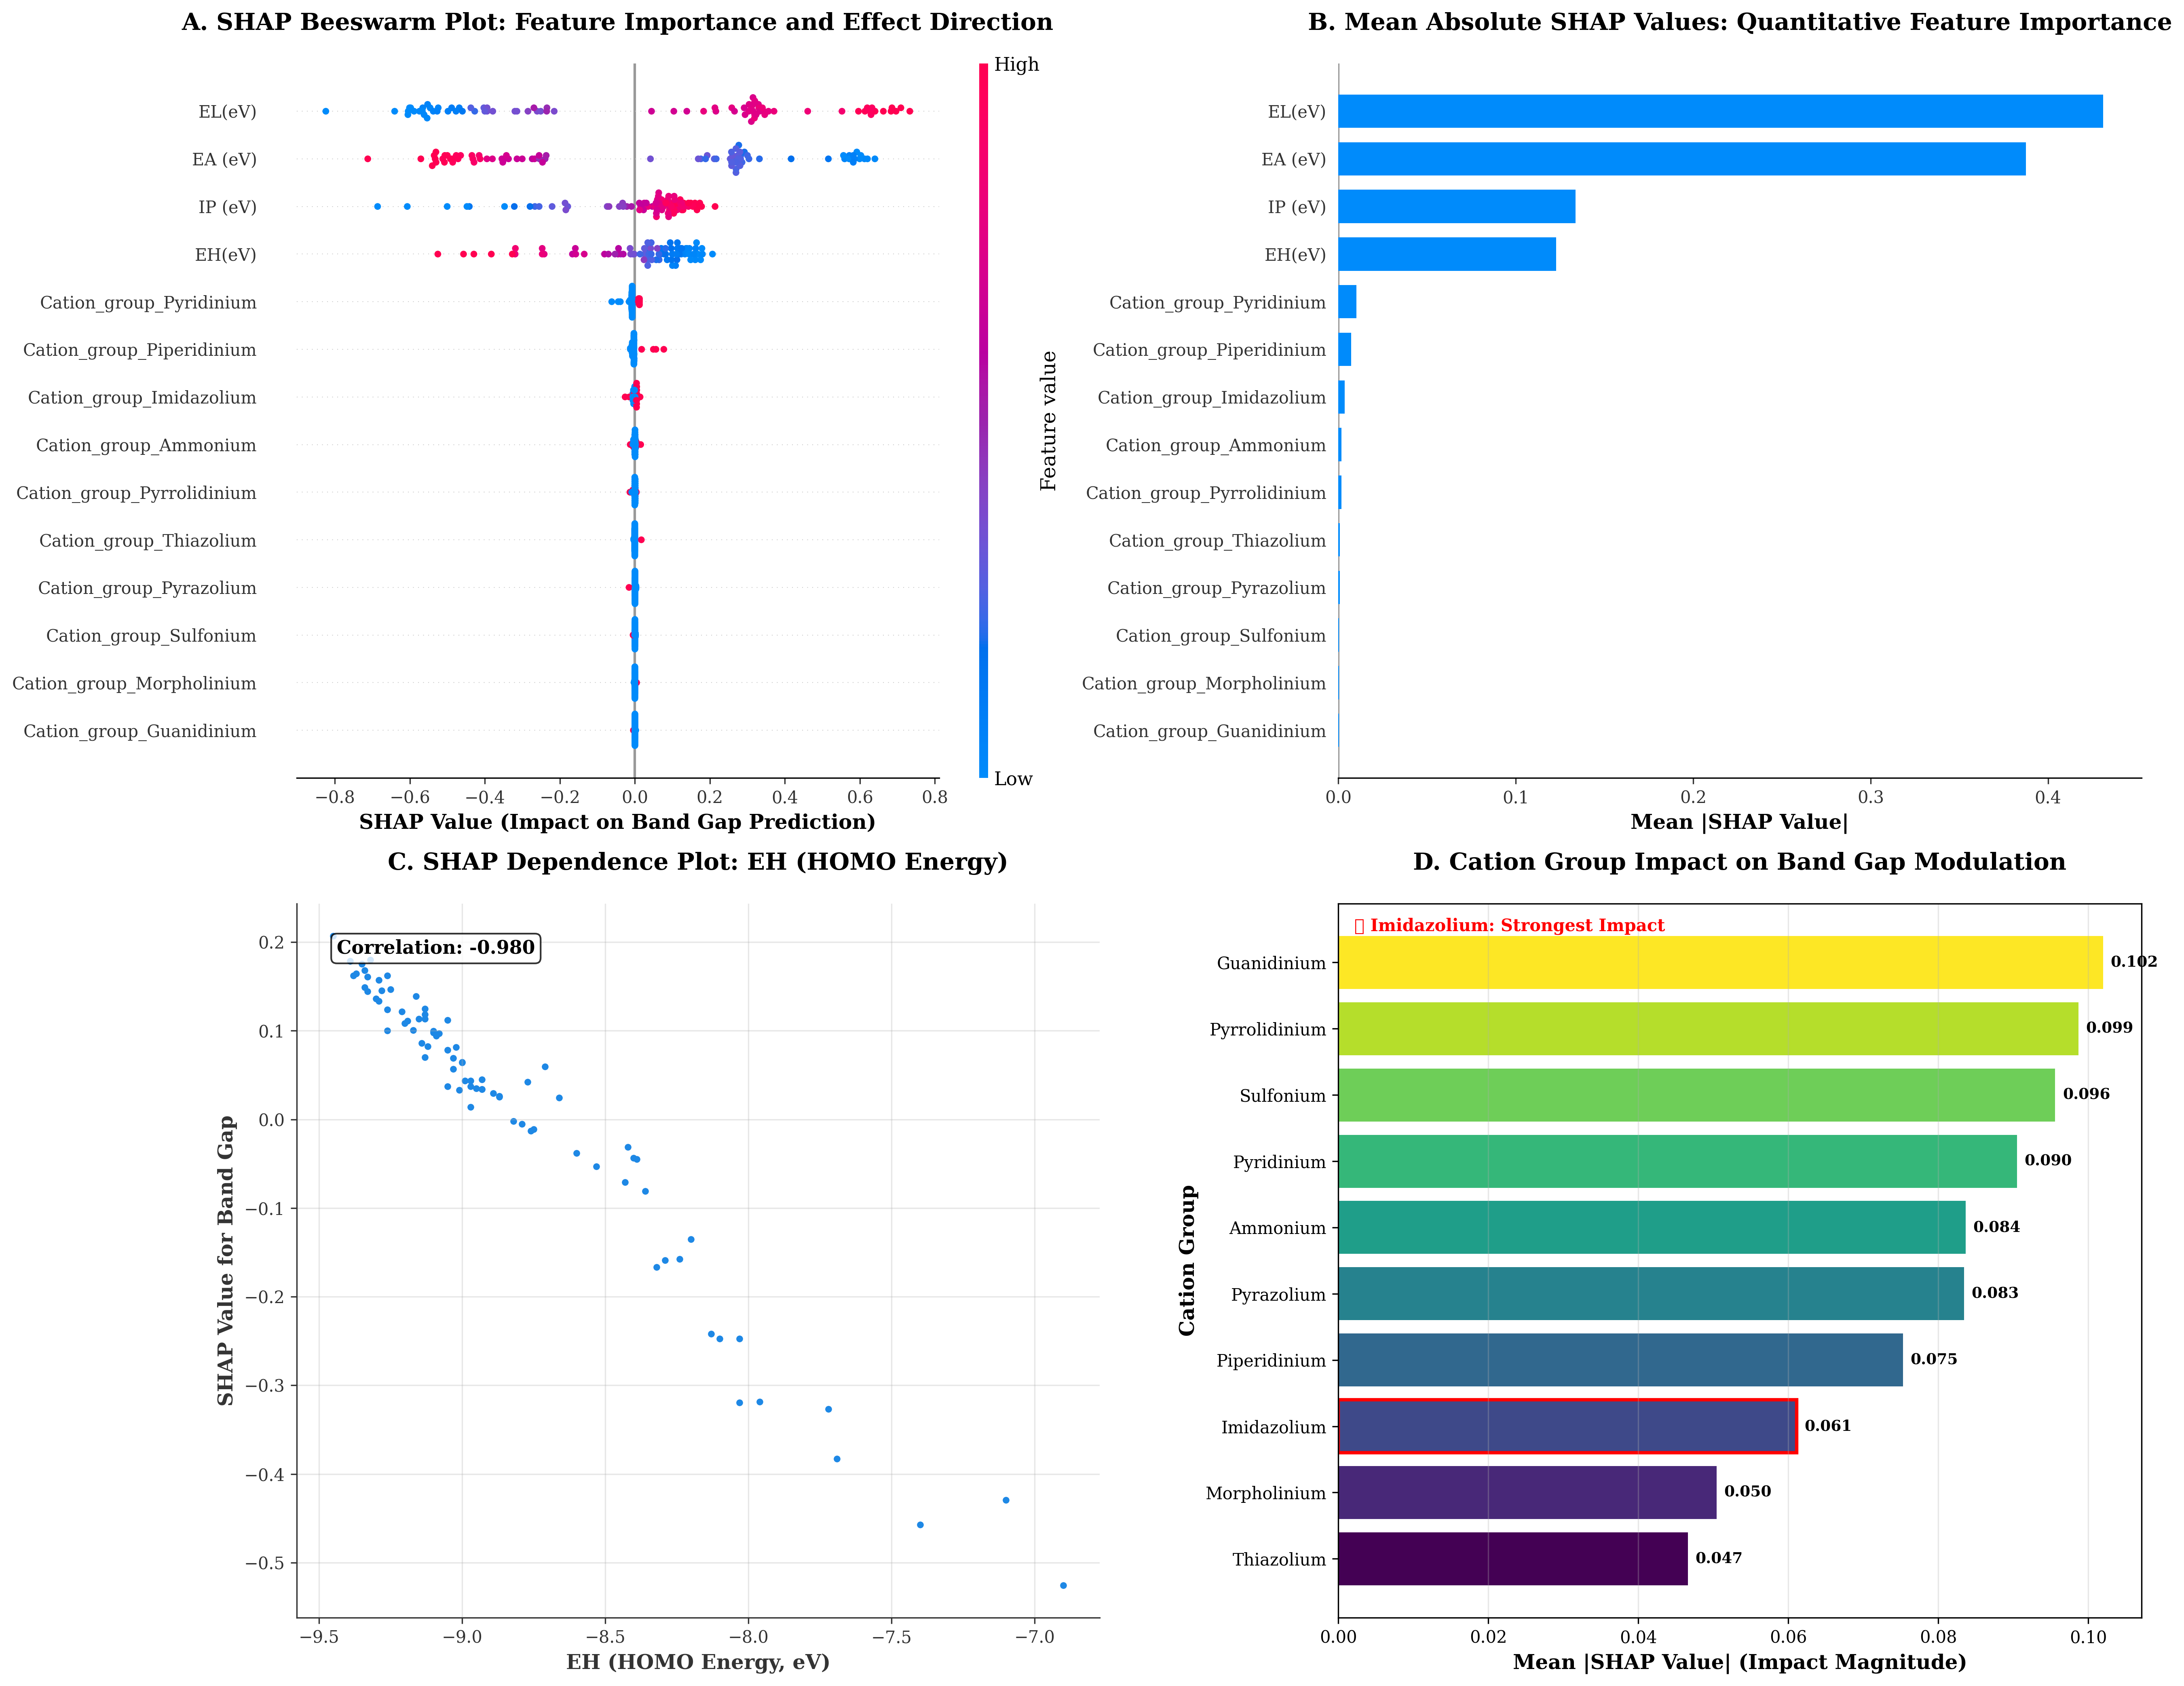

SHAP ANALYSIS KEY INSIGHTS

Top 5 Most Important Features:
  1. EL(eV): 0.4311
  2. EA (eV): 0.3877
  3. IP (eV): 0.1336
  4. EH(eV): 0.1228
  5. Cation_group_Pyridinium: 0.0100

Cation Group Impact Ranking:
  1. Guanidinium: 0.1020
  2. Pyrrolidinium: 0.0987
  3. Sulfonium: 0.0956
  4. Pyridinium: 0.0905
  5. Ammonium: 0.0836
  6. Pyrazolium: 0.0834
  7. Piperidinium: 0.0753
  8. Imidazolium: 0.0611
  9. Morpholinium: 0.0504
  10. Thiazolium: 0.0466

EH (HOMO Energy) Correlation with SHAP values: -0.980
Negative correlation indicates higher EH values decrease band gap prediction


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Figure 56 has been generated and downloaded successfully!
The figure includes:
A. Beeswarm plot showing feature importance and effect direction
B. Bar plot of mean absolute SHAP values
C. Dependence plot for EH (HOMO energy)
D. Cation group impact analysis


In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Set style for publication-quality figures
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = True

# Load and prepare data
df = pd.read_excel('Dataset.xlsx', sheet_name='Sheet1')
features = ['EH(eV)', 'EL(eV)', 'IP (eV)', 'EA (eV)', 'Cation_group']
target = 'Eg (eV)'

# Convert categorical variables
df_encoded = pd.get_dummies(df[features + [target]], columns=['Cation_group'])
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best model (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Create the 4-panel figure
fig = plt.figure(figsize=(18, 14))

# Panel A: Beeswarm plot
ax1 = fig.add_subplot(2, 2, 1)
shap.summary_plot(shap_values, X_train, feature_names=X.columns, show=False, plot_size=None)
ax1.set_title('A. SHAP Beeswarm Plot: Feature Importance and Effect Direction',
              fontweight='bold', fontsize=14, pad=20)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_xlabel('SHAP Value (Impact on Band Gap Prediction)', fontweight='bold', fontsize=12)

# Panel B: Mean absolute SHAP values (Bar plot)
ax2 = fig.add_subplot(2, 2, 2)
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="bar", show=False, plot_size=None)
ax2.set_title('B. Mean Absolute SHAP Values: Quantitative Feature Importance',
              fontweight='bold', fontsize=14, pad=20)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_xlabel('Mean |SHAP Value|', fontweight='bold', fontsize=12)

# Panel C: Dependence plot for EH (HOMO energy)
ax3 = fig.add_subplot(2, 2, 3)
shap.dependence_plot("EH(eV)", shap_values, X_train, feature_names=X.columns,
                     ax=ax3, show=False, interaction_index=None)
ax3.set_title('C. SHAP Dependence Plot: EH (HOMO Energy)',
              fontweight='bold', fontsize=14, pad=20)
ax3.set_xlabel('EH (HOMO Energy, eV)', fontweight='bold', fontsize=12)
ax3.set_ylabel('SHAP Value for Band Gap', fontweight='bold', fontsize=12)
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.grid(True, alpha=0.3)

# Add correlation coefficient
eh_corr = np.corrcoef(X_train['EH(eV)'], shap_values[:, X.columns.get_loc('EH(eV)')])[0, 1]
ax3.text(0.05, 0.95, f'Correlation: {eh_corr:.3f}', transform=ax3.transAxes,
         fontsize=11, fontweight='bold', verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel D: Cation group impact analysis
ax4 = fig.add_subplot(2, 2, 4)
cation_columns = [col for col in X.columns if 'Cation_group' in col]
cation_shap_means = {}

for cation in cation_columns:
    mask = X_train[cation] == 1
    if mask.sum() > 0:
        cation_name = cation.replace('Cation_group_', '').replace('_', ' ').title()
        cation_shap_means[cation_name] = np.mean(np.abs(shap_values[mask]).mean(0))

cation_importance = pd.Series(cation_shap_means).sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(cation_importance)))

bars = ax4.barh(range(len(cation_importance)), cation_importance.values, color=colors)
ax4.set_yticks(range(len(cation_importance)))
ax4.set_yticklabels(cation_importance.index)
ax4.set_xlabel('Mean |SHAP Value| (Impact Magnitude)', fontweight='bold', fontsize=12)
ax4.set_ylabel('Cation Group', fontweight='bold', fontsize=12)
ax4.set_title('D. Cation Group Impact on Band Gap Modulation',
              fontweight='bold', fontsize=14, pad=20)
ax4.grid(True, alpha=0.3, axis='x')

# Add values to bars
for i, (cation, impact) in enumerate(cation_importance.items()):
    ax4.text(impact + 0.001, i, f'{impact:.3f}', va='center', fontsize=9, fontweight='bold')

# Highlight imidazolium group
imidazolium_idx = [i for i, cation in enumerate(cation_importance.index) if 'Imidazolium' in cation]
if imidazolium_idx:
    ax4.patches[imidazolium_idx[0]].set_edgecolor('red')
    ax4.patches[imidazolium_idx[0]].set_linewidth(2)
    ax4.text(0.02, 0.98, '★ Imidazolium: Strongest Impact', transform=ax4.transAxes,
             fontsize=10, fontweight='bold', color='red', verticalalignment='top')

plt.tight_layout()
plt.savefig('Figure_56_SHAP_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print key insights
print("="*70)
print("SHAP ANALYSIS KEY INSIGHTS")
print("="*70)

# Top features
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
top_features_idx = np.argsort(mean_abs_shap)[::-1][:5]
print("\nTop 5 Most Important Features:")
for i, idx in enumerate(top_features_idx):
    feature = X.columns[idx]
    importance = mean_abs_shap[idx]
    print(f"  {i+1}. {feature}: {importance:.4f}")

# Cation group insights
print(f"\nCation Group Impact Ranking:")
for i, (cation, impact) in enumerate(cation_importance.sort_values(ascending=False).items()):
    print(f"  {i+1}. {cation}: {impact:.4f}")

# EH correlation insight
print(f"\nEH (HOMO Energy) Correlation with SHAP values: {eh_corr:.3f}")
print("Negative correlation indicates higher EH values decrease band gap prediction")

# Download the figure
from google.colab import files
files.download('Figure_56_SHAP_Analysis.png')

print("\nFigure 56 has been generated and downloaded successfully!")
print("The figure includes:")
print("A. Beeswarm plot showing feature importance and effect direction")
print("B. Bar plot of mean absolute SHAP values")
print("C. Dependence plot for EH (HOMO energy)")
print("D. Cation group impact analysis")